# Kernel Search

## Setup

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary, set_trainable
import pickle
from helper_functions import *
import os

# Options
sns.set_theme(
    context='paper',
    style='white',
    palette='colorblind'
)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Kernel Search Experiment

In [2]:
# Read in saved object with experimental data
sim_df = pickle.load(open("sim_exp_data.pkl", "rb"))

In [3]:
sim_df[2].head()

id  treat  time  y1_nonoise  y2_nonoise  y3_nonoise  y4_nonoise  \
0  0.0    0.0   3.4    0.149705   -1.206594    2.343908   -0.989183   
1  0.0    0.0  11.2    0.010766   -0.770236    6.302871    6.859738   
2  1.0    0.0   9.5    1.933597    1.453169    4.880455    4.945178   
3  1.0    0.0  10.0    2.556660   -1.160536    5.142014    5.793136   
4  2.0    1.0   9.9    0.840374    1.055590    0.571689   -1.259144   

   y1_rate_2_eps_01  y1_rate_2_eps_1  y1_rate_2_eps_10  y2_rate_2_eps_01  \
0          0.149365         2.158265        -14.693472         -1.206934   
1         -0.082640         1.247650        -10.039463         -0.863642   
2          1.929257         3.360547         15.257888          1.448829   
3          2.582918         2.365575         10.655877         -1.134278   
4          0.796418        -0.282274          0.879909          1.011633   

   y2_rate_2_eps_1  y2_rate_2_eps_10  y3_rate_2_eps_01  y3_rate_2_eps_1  \
0         0.801966        -16.049771          2.343568         4.352468   
1         0.466649        -10.820465          6.209465         7.539755   
2         2.880119         14.777460          4.876116         6.307406   
3        -1.351621          6.938681          5.168272         4.950929   
4        -0.067058          1.095125          0.527732        -0.550959   

   y3_rate_2_eps_10  y4_rate_2_eps_01  y4_rate_2_eps_1  y4_rate_2_eps_10  
0        -12.499269         -0.989524         1.019376        -15.832361  
1         -3.747358          6.766331         8.096622         -3.190491  
2         18.204747          4.940838         6.372128         18.269469  
3         13.241230          5.819394         5.602051         13.892352  
4          0.611224         -1.303101        -2.381792         -1.219609

### Small Rate

In [4]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               #gpflow.kernels.Matern32(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]
rate = 2

# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Kernel search", total=16)) as progress_bar:
    search_out_small = Parallel(n_jobs=-3, verbose=1)(delayed(full_kernel_search)(
        X=sim_df[rate][['id', 'treat', 'time']].\
            assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
            to_numpy().\
            reshape(-1, 3),
        Y=sim_df[rate].drop(columns=['id', 'treat', 'time']).to_numpy()[:, i].reshape(-1, 1),
        kern_list=kernel_list,
        cat_vars=[0, 1],
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        keep_only_best=True,
        lik='gaussian',
        random_seed=9102
    )
    for i in range(16))

Kernel search: 100%|████████████████████████████| 16/16 [02:57<00:00, 11.10s/it]


In [5]:
# Save output
f = open("search_out_small.pkl","wb")
pickle.dump(search_out_small, f)
f.close()

In [4]:
# Load if needed
search_out_small = pickle.load(open( "search_out_small.pkl", "rb" ))

In [7]:
for x in range(16):
    print(f"Output: {sim_df[rate].columns[x+3]}, Kernel: {search_out_small[x]['best_model']}")
    if x in [3,6,9,12]:
        print('')

Output: y1_nonoise, Kernel: categorical[0]+matern12[2]
Output: y2_nonoise, Kernel: matern12[2]*categorical[0]+periodic[2]
Output: y3_nonoise, Kernel: categorical[1]*squared_exponential[2]+categorical[0]*periodic[2]
Output: y4_nonoise, Kernel: categorical[1]*polynomial[2]

Output: y1_rate_2_eps_01, Kernel: categorical[0]+matern12[2]
Output: y1_rate_2_eps_1, Kernel: categorical[0]+matern12[2]
Output: y1_rate_2_eps_10, Kernel: constant

Output: y2_rate_2_eps_01, Kernel: squared_exponential[2]
Output: y2_rate_2_eps_1, Kernel: matern12[2]
Output: y2_rate_2_eps_10, Kernel: constant

Output: y3_rate_2_eps_01, Kernel: categorical[1]*polynomial[2]+categorical[0]
Output: y3_rate_2_eps_1, Kernel: categorical[1]*squared_exponential[2]+categorical[0]
Output: y3_rate_2_eps_10, Kernel: categorical[1]*linear[2]

Output: y4_rate_2_eps_01, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_2_eps_1, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_2_eps_10, Kernel: categorical[1]*linear[2]


In [8]:
# # Run the softmax search operator for comparison if interested
# %%time
# np.random.seed(9102)
# softmax_foo = softmax_kernel_search(
#     X=sim_df[3][['id', 'treat', 'time']].\
#         assign(time = (sim_df[3].time - small_time_mean)/small_time_std).\
#         to_numpy().\
#         reshape(-1, 3),
#     Y=sim_df[3].drop(columns=['id', 'treat', 'time']).to_numpy()[:, 3].reshape(-1, 1),
#     kern_list=kernel_list,
#     cat_vars=[0, 1],
#     max_depth=3,
#     num_trials=10,
#     # early_stopping=True,
#     # prune=False,
#     # keep_all=True,
#     # softmax_select=True,
#     # keep_only_best=False,
#     lik='gaussian',
#     verbose=False
# )

In [9]:
# Plot resulting BIC and edges
# TODO: Does not currently work with packages - need graphviz

# import matplotlib.pyplot as plt
# import networkx as nx

# g = nx.Graph()
# # # add 30 unconnected nodes
# g.add_nodes_from({key: foo[0][key][2] for key in foo[0].keys()})
# # add 15 2-node components
# # g.add_edges_from([(ii, ii+1) for ii in range(30, 60, 2)])
# g.add_edges_from(foo[1])
# #, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')
# # nx.draw_spectral(g, node_color=[foo[0][key][2] for key in foo[0].keys()], with_labels=True) 
# nx.drawing.nx_agraph.to_agraph(g)

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.

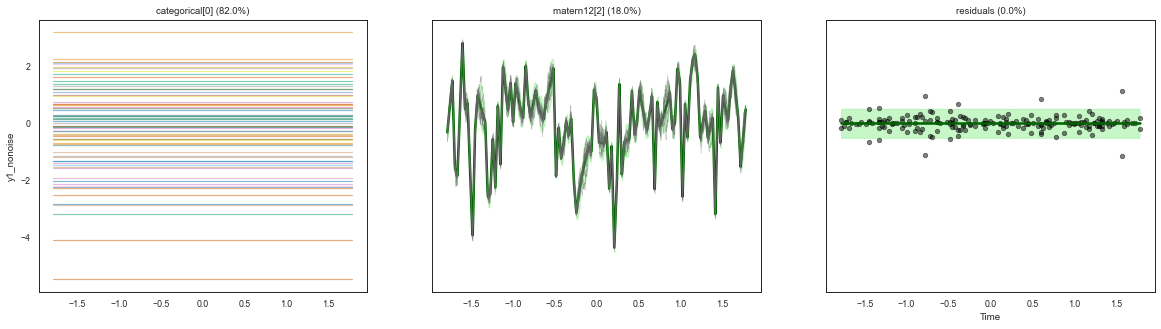

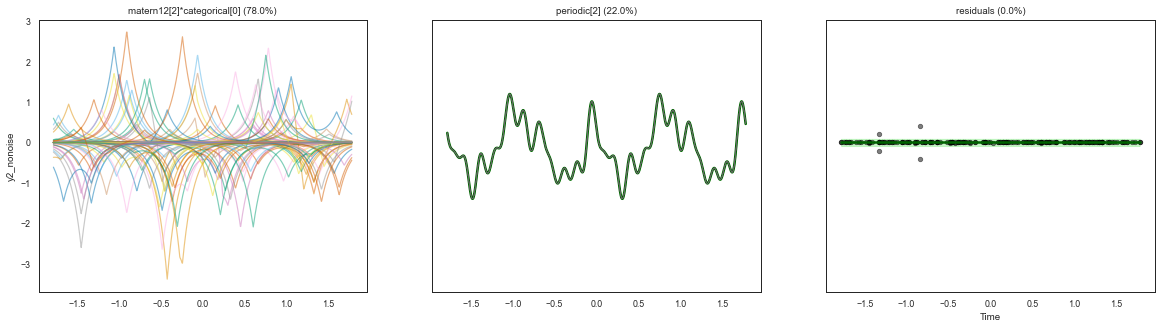

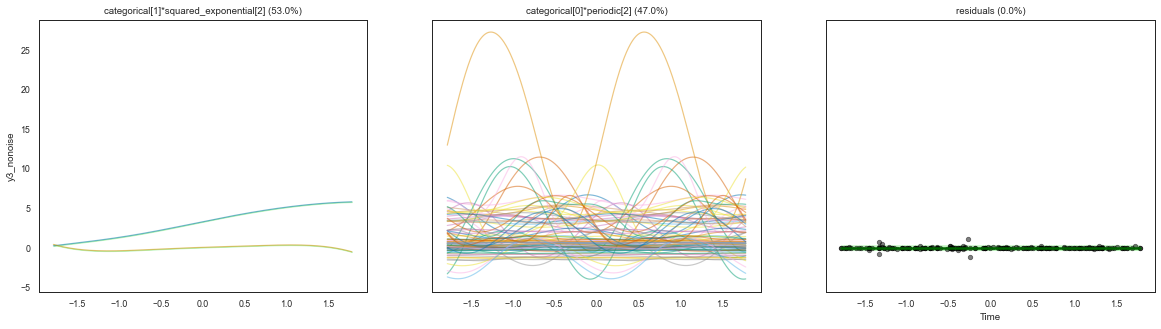

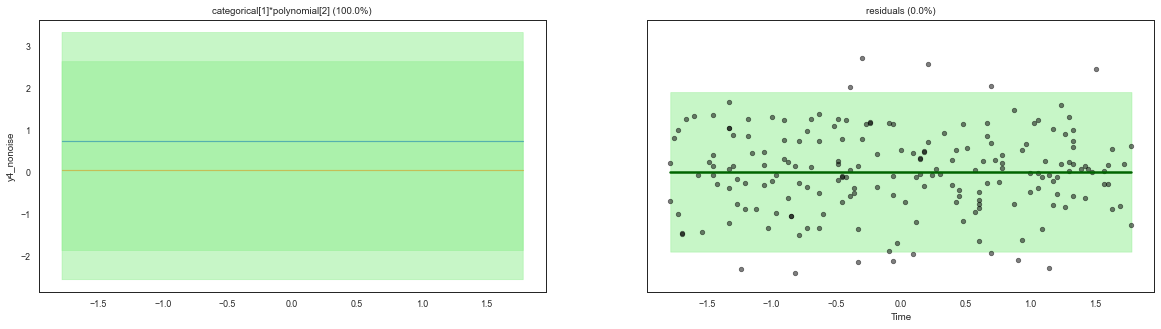

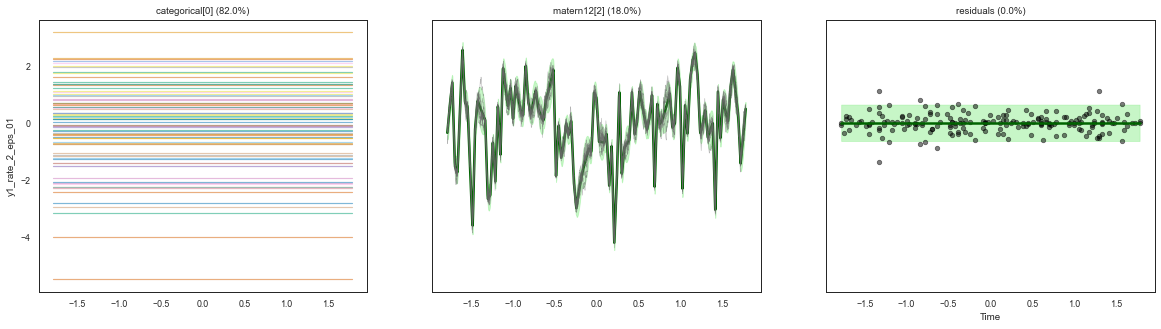

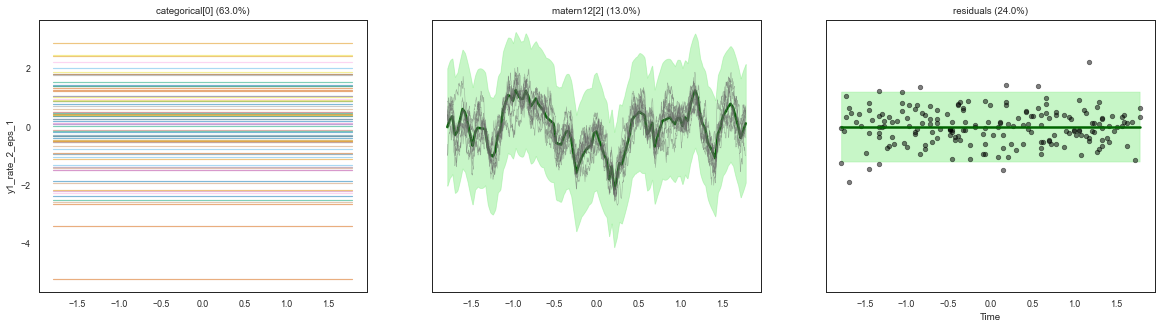

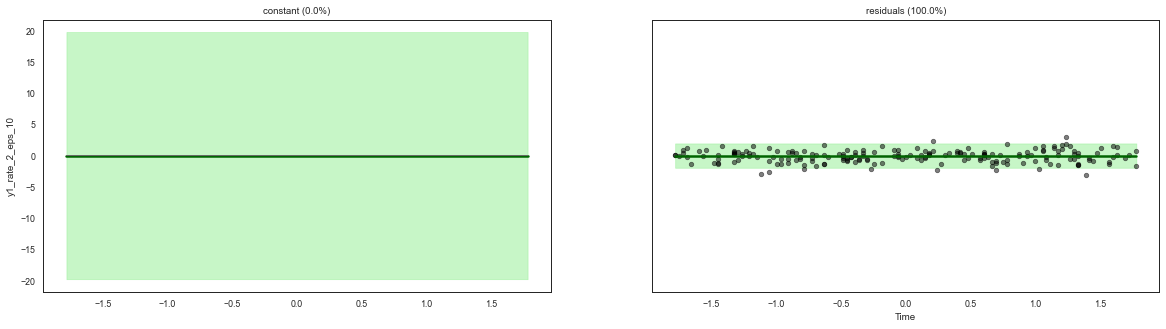

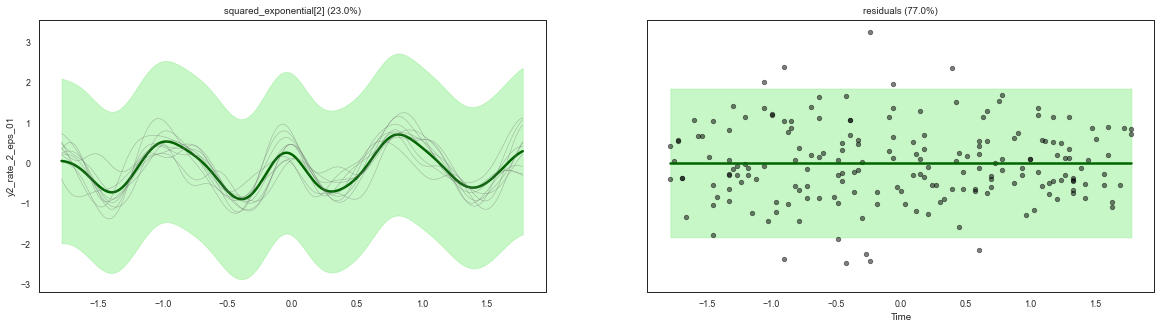

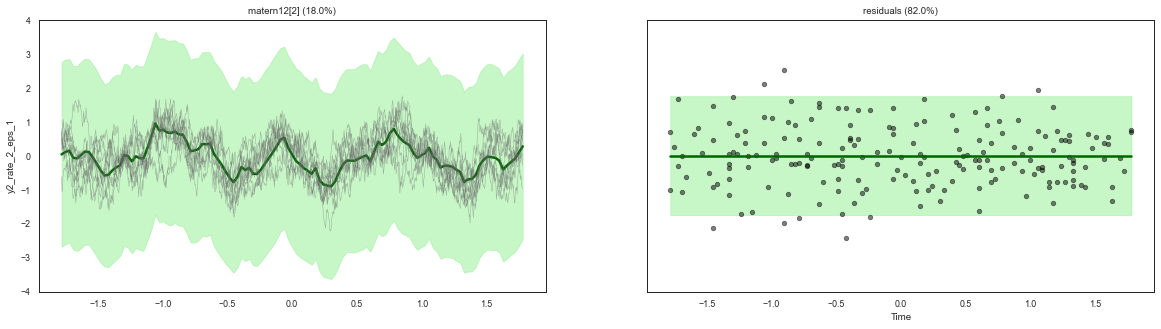

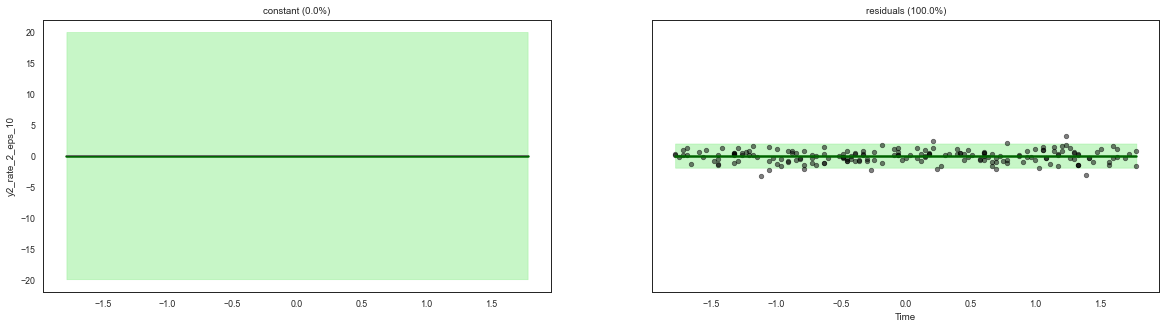

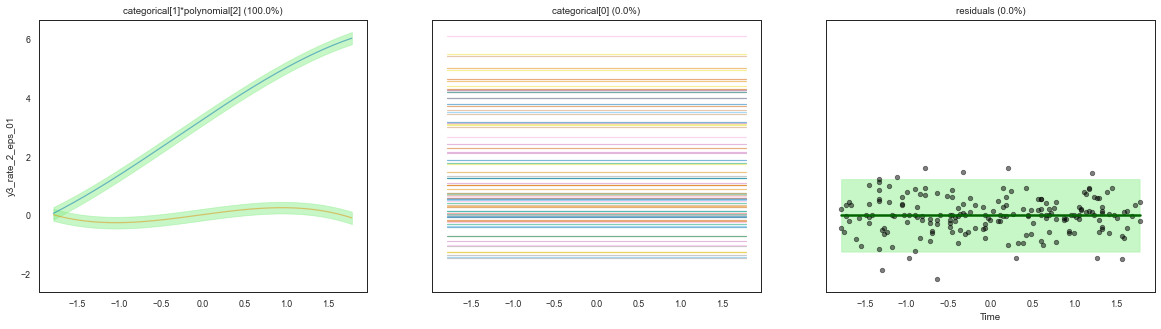

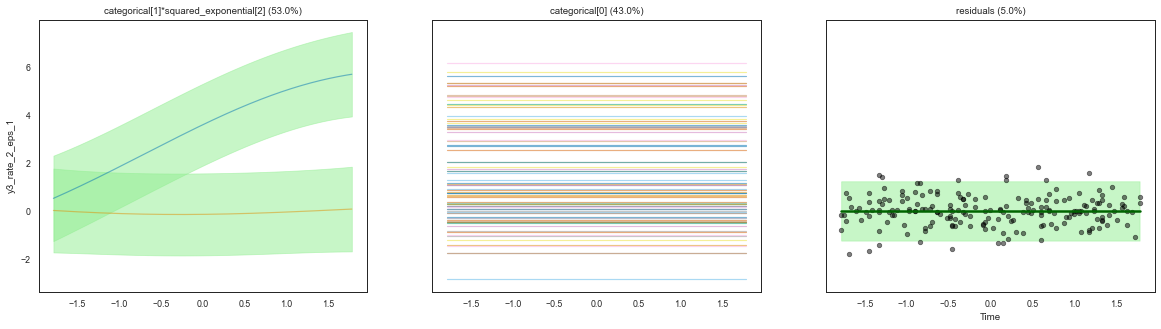

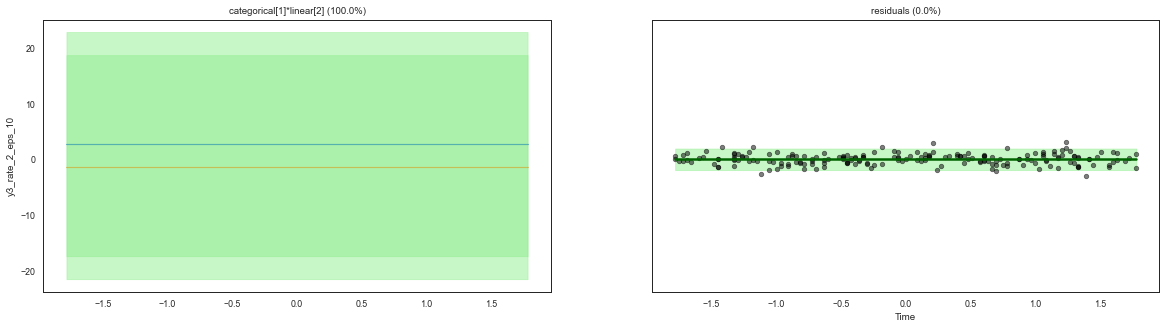

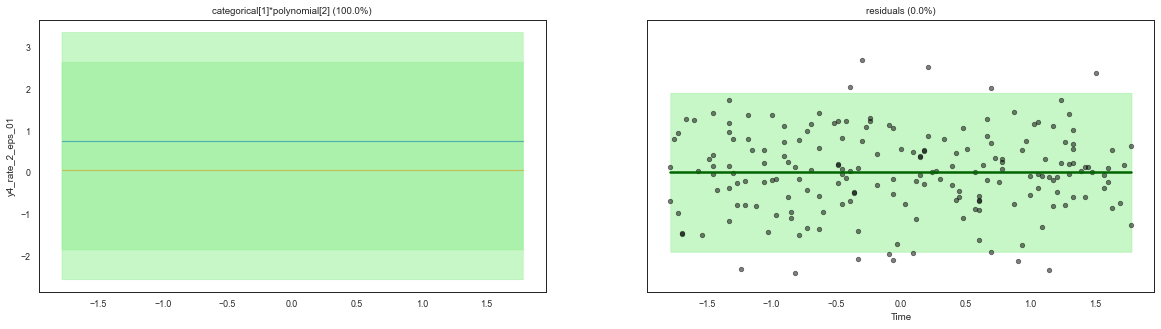

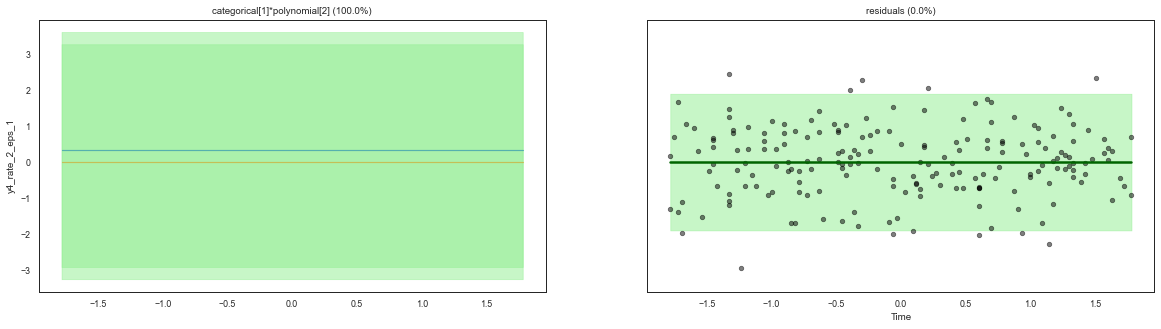

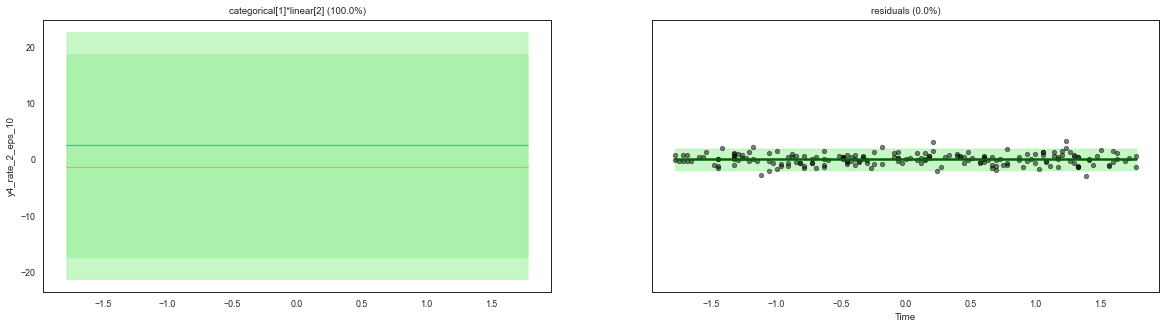

In [10]:
for i in range(16):
    f, a = pred_kernel_parts2(
        search_out_small[i]['models'][search_out_small[i]['best_model']]['model'],
        search_out_small[i]['best_model'],
        time_idx=2,
        unit_idx=0
    )
    f.set_size_inches(20, 5)
    # f.suptitle(sim_df[3].columns[i+3])
    a[0].set_ylabel(sim_df[rate].columns[i+3])
    #a[0].set_ylim(-3, 3)
    # a[1].set_xlabel('Time')
    #a[1].set_ylim(-3, 3)
    

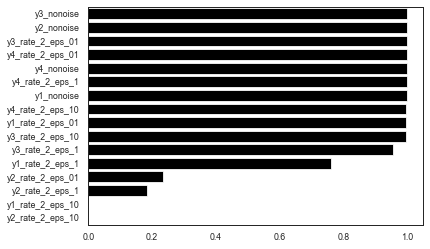

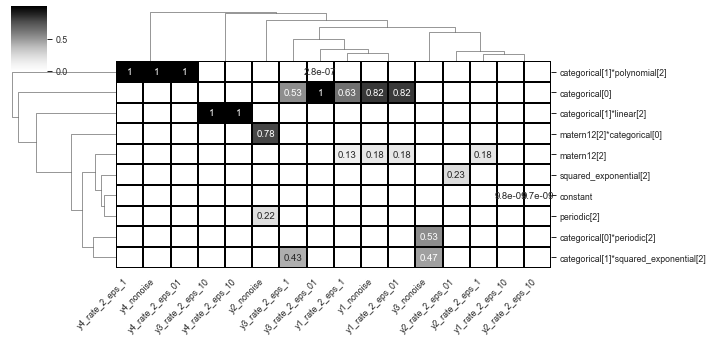

In [11]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in search_out_small]
var_components = [x['var_exp'] for x in search_out_small]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

# sns.barplot(
#     y=sim_df[3].columns[3:], #np.arange(Y.shape[1]).astype(str), 
#     x=var_explained,
#     color='black'
# )
sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=sim_df[rate].columns[3:][np.argsort(var_explained)[::-1]],
    color='black'
)

kernels = [x['best_model'].split('+') for x in search_out_small]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

# sns.clustermap(pd.DataFrame(kernel_array, 
#                             index=sim_df[3].columns[3:], #np.arange(Y.shape[1]),
#                             columns=distinct_kernels),
#               figsize=(5,10),
#               cmap='Greys',
#               linecolor='black',
#               linewidths=1.5)
clm = sns.clustermap(pd.DataFrame(kernel_array, 
                            index=sim_df[rate].columns[3:], #np.arange(Y.shape[1]),
                            columns=distinct_kernels).transpose(),
              figsize=(10, 5),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              annot=True)
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
for t in clm.ax_heatmap.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

In [18]:
# Example for posterior sampling
# samples_out7 = hmc_sampling(
#     model=search_out_small[7]['models'][search_out_small[7]['best_model']]['model'],
#     burn_in=500,
#     samples=1000
# )

In [5]:
# samples_out = hmc_sampling(
#     model=search_out_small[0][0][search_out_small[0][2]][1],
#     burn_in=500,
#     samples=500
# )
# Sample from the posterior for each 'best' model
with tqdm_joblib(tqdm(desc="Posterior sampling", total=16)) as progress_bar:
    samples_out_small = Parallel(n_jobs=-2, verbose=1)(delayed(hmc_sampling)(
        model=search_out_small[i]['models'][search_out_small[i]['best_model']]['model'],
        burn_in=200,
        samples=500)
    for i in range(16))

Posterior sampling: 100%|███████████████████████| 16/16 [44:06<00:00, 81.18s/it][Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed: 44.1min finished
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed: 44.1min remaining:    0.0s
Posterior sampling: 100%|██████████████████████| 16/16 [44:06<00:00, 165.39s/it]


In [6]:
# Save optimizerst
f = open("samples_out_small.pkl","wb")
pickle.dump(samples_out_small, f)
f.close()

In [14]:
search_out_small[0]['models'][search_out_small[0]['best_model']]['model'].trainable_parameters

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=2.2599871669535316>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.15415308927786203>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.48392229853045826>,
 <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.0005627949125499613>)

In [52]:
search_out_small[0]['models'][search_out_small[0]['best_model']]['model']

<gpflow.models.gpr.GPR object at 0x7fd13ede9970>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.25999     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.483922    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.154153    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.000562795 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

In [18]:
len(samples_out_small[0]['samples'])

4

In [54]:
# Pull of samples from posterior
samples_pd = pd.DataFrame(
    data=np.column_stack([x.numpy() for x in samples_out_small[0]['samples']]),
    columns=['categorical[0]_variance', 'matern12[2]_variance', 'matern12[2]_lengthscales', 'noise']
)

samples_pd_long = pd.melt(samples_pd)

In [72]:
pd.DataFrame(samples_pd.mean(axis=0)).T

categorical[0]_variance  matern12[2]_variance  matern12[2]_lengthscales  \
0                 2.160056              0.184115                  0.685447   

      noise  
0  0.000684

In [83]:
samples_pd_long = pd.melt(
    pd.concat(
        [samples_pd.quantile([0.1, 0.9]), 
         pd.DataFrame(samples_pd.mean(axis=0)).T]).\
        assign(metric = ['percentile_10', 'percentile_90', 'mean']),
    id_vars=['metric']
)

In [84]:
samples_pd_long

metric                  variable     value
0   percentile_10   categorical[0]_variance  1.791830
1   percentile_90   categorical[0]_variance  2.552174
2            mean   categorical[0]_variance  2.160056
3   percentile_10      matern12[2]_variance  0.099396
4   percentile_90      matern12[2]_variance  0.285000
5            mean      matern12[2]_variance  0.184115
6   percentile_10  matern12[2]_lengthscales  0.414579
7   percentile_90  matern12[2]_lengthscales  1.020122
8            mean  matern12[2]_lengthscales  0.685447
9   percentile_10                     noise  0.000434
10  percentile_90                     noise  0.001011
11           mean                     noise  0.000684

In [ ]:
sns.pointplot(
    x="", 
    y="total_bill", 
    hue="smoker",
    data=samples_pd_long
)

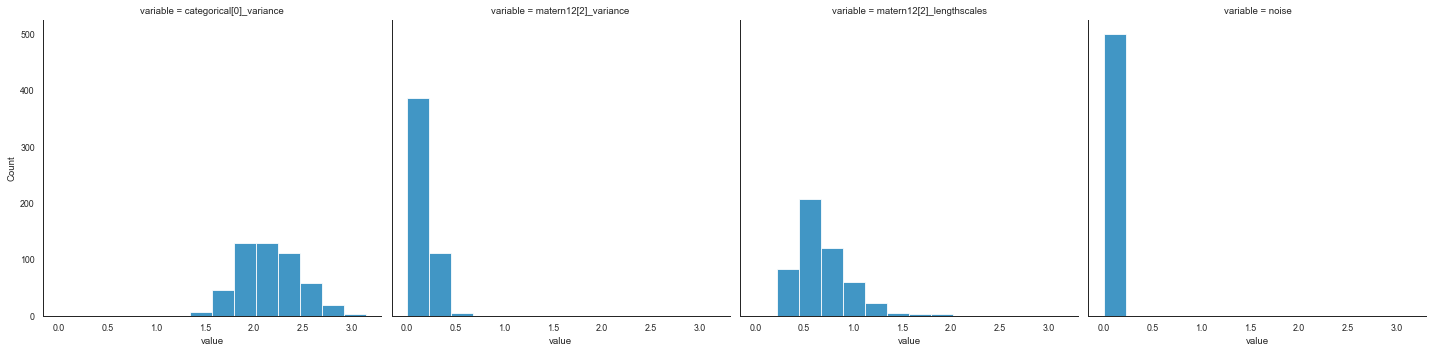

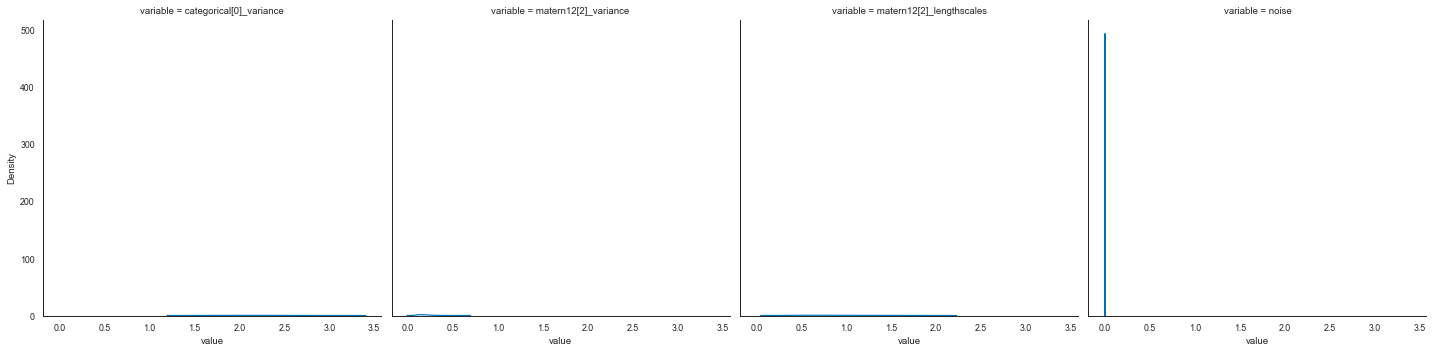

In [56]:
# f, ax = plt.subplots(nrows=1, ncols=4)
# for i, v in enumerate(samples_out[0]):
#     # plt.figure()
#     # plt.hist(v.numpy())
#     ax[i] = sns.displot(v.numpy())
    
sns.displot(
    data=samples_pd_long,
    x='value',
    col='variable'
)
sns.displot(
    data=samples_pd_long,
    x='value',
    col='variable',
    kind='kde'
)

In [8]:
# foo = gpflow.models.GPR(
#     data = (sim_df[4][['id', 'treat', 'time']].to_numpy().reshape(-1, 3),
#             sim_df[4].drop(columns=['id', 'treat', 'time']).to_numpy()[:, 8].reshape(-1, 1)),
#     kernel = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(active_dims=[2])),
#         # Categorical(active_dims=[0]) * gpflow.kernels.Linear(active_dims=[2]),
#         # gpflow.kernels.SquaredExponential(active_dims=[2]) * gpflow.kernels.SquaredExponential(active_dims=[2]),
#     mean_function=gpflow.mean_functions.Constant()
# )

# optimizer = gpflow.optimizers.Scipy()
# optimizer.minimize(foo.training_loss, foo.trainable_variables)

# foo_bic = calc_bic(
#     foo.log_marginal_likelihood(), 
#     foo.data[0].shape[0], 
#     len(foo.trainable_parameters)
# )

# print(f'BIC: {foo_bic}')

# foo
# foo.kernel.K(foo.data[0][:, 2].numpy().reshape(-1, 1))

### Medium Rate

In [14]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               #gpflow.kernels.Matern32(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

rate = 4

# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Kernel search", total=16)) as progress_bar:
    search_out_med = Parallel(n_jobs=-3, verbose=1)(delayed(full_kernel_search)(
        X=sim_df[rate][['id', 'treat', 'time']].\
            assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
            to_numpy().\
            reshape(-1, 3),
        Y=sim_df[rate].drop(columns=['id', 'treat', 'time']).to_numpy()[:, i].reshape(-1, 1),
        kern_list=kernel_list,
        cat_vars=[0, 1],
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        lik='gaussian',
        random_seed=9102,
        keep_only_best=False
    )
    for i in range(16))

Kernel search: 100%|████████████████████████████| 16/16 [09:49<00:00, 36.85s/it]


In [21]:
# Save output
f = open("search_out_med.pkl","wb")
pickle.dump(search_out_med, f)
f.close()

In [22]:
# Load if needed
search_out_med = pickle.load(open("search_out_med.pkl", "rb" ))

In [15]:
for x in range(16):
    print(f"Output: {sim_df[rate].columns[x+3]}, Kernel: {search_out_med[x]['best_model']}")
    if x in [3,6,9,12]:
        print('')

Output: y1_nonoise, Kernel: categorical[0]+matern12[2]
Output: y2_nonoise, Kernel: matern12[2]*periodic[2]+categorical[0]*matern12[2]
Output: y3_nonoise, Kernel: categorical[1]*polynomial[2]+categorical[0]
Output: y4_nonoise, Kernel: categorical[1]*polynomial[2]

Output: y1_rate_4_eps_01, Kernel: categorical[0]+matern12[2]
Output: y1_rate_4_eps_1, Kernel: categorical[0]+matern12[2]
Output: y1_rate_4_eps_10, Kernel: constant

Output: y2_rate_4_eps_01, Kernel: matern12[2]*periodic[2]+categorical[0]*matern12[2]
Output: y2_rate_4_eps_1, Kernel: matern12[2]*periodic[2]
Output: y2_rate_4_eps_10, Kernel: constant

Output: y3_rate_4_eps_01, Kernel: categorical[1]*polynomial[2]+categorical[0]
Output: y3_rate_4_eps_1, Kernel: categorical[1]*squared_exponential[2]+categorical[0]
Output: y3_rate_4_eps_10, Kernel: categorical[1]

Output: y4_rate_4_eps_01, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_4_eps_1, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_4_eps_10, Kernel: categorical[

In [29]:
search_out_med[1]['models']['periodic[2]']['model'].kernel

<gpflow.kernels.periodic.Periodic object at 0x7fad39fac940>
╒═══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                              │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ Periodic.base_kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.272135  │
├───────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Periodic.base_kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.0149739 │
├───────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Periodic.period                   │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.182657  │
╘═══════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [33]:
search_out_med[1]['models']['matern12[2]*periodic[2]+categorical[0]*matern12[2]']['model'].kernel.kernels[0].kernels

ListWrapper([<gpflow.kernels.stationaries.Matern12 object at 0x7fad2837ab80>, <gpflow.kernels.periodic.Periodic object at 0x7fad28383130>])

In [24]:
search_out_med[1]['models']['matern12[2]*periodic[2]+categorical[0]*matern12[2]']['model'].kernel.kernels

ListWrapper([<gpflow.kernels.base.Product object at 0x7fad2837aaf0>, <gpflow.kernels.base.Product object at 0x7fad28383ac0>])

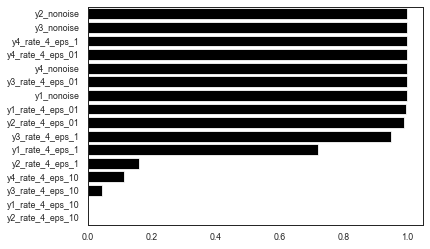

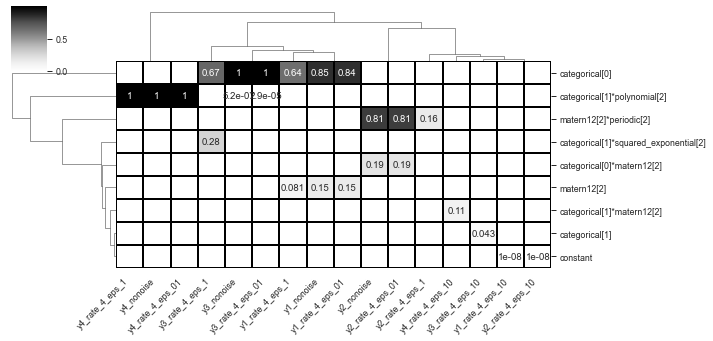

In [13]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in search_out_med]
var_components = [x['var_exp'] for x in search_out_med]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]


sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=sim_df[rate].columns[3:][np.argsort(var_explained)[::-1]],
    color='black'
)

kernels = [x['best_model'].split('+') for x in search_out_med]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

clm = sns.clustermap(pd.DataFrame(kernel_array, 
                            index=sim_df[rate].columns[3:], #np.arange(Y.shape[1]),
                            columns=distinct_kernels).transpose(),
              figsize=(10, 5),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              annot=True)
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
for t in clm.ax_heatmap.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.

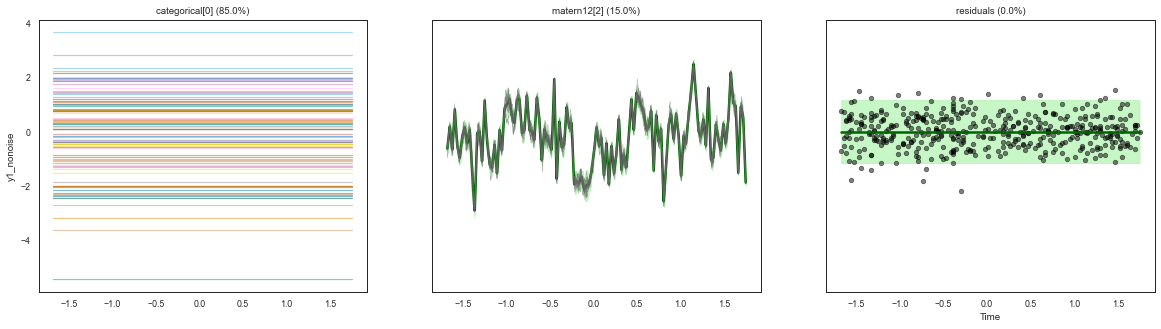

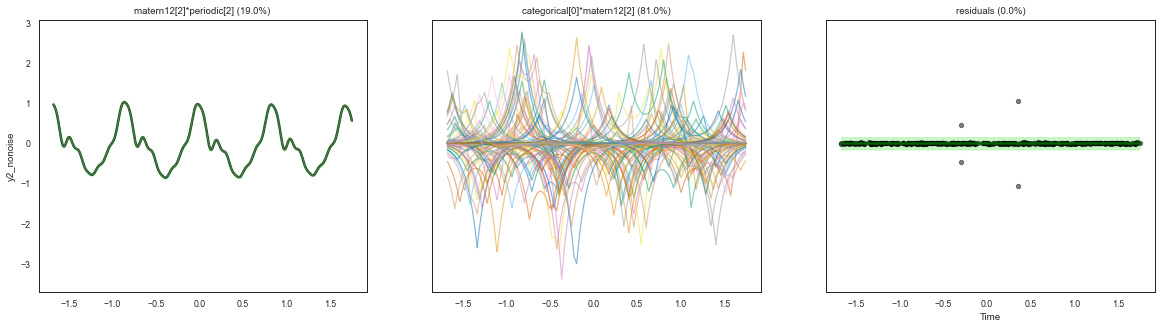

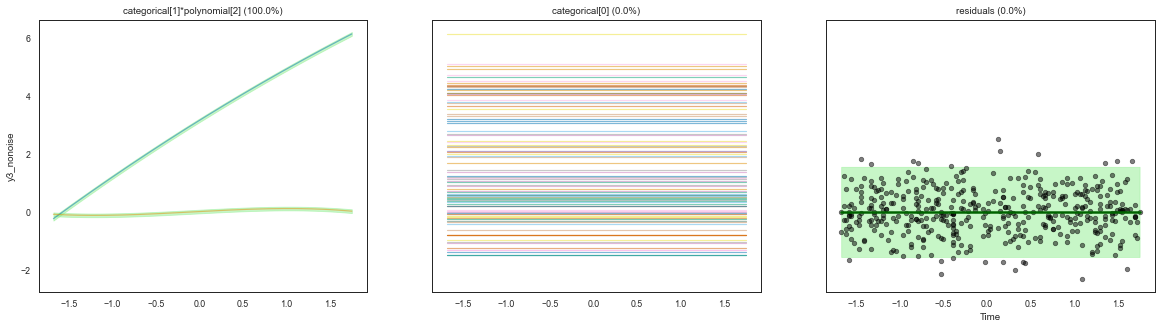

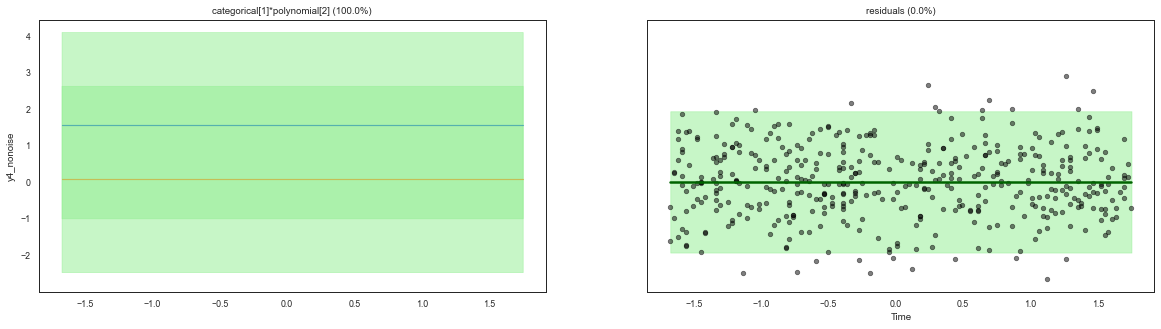

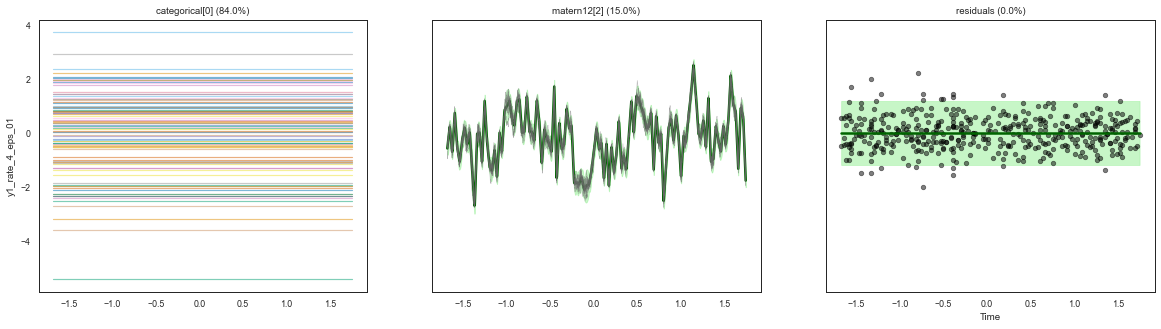

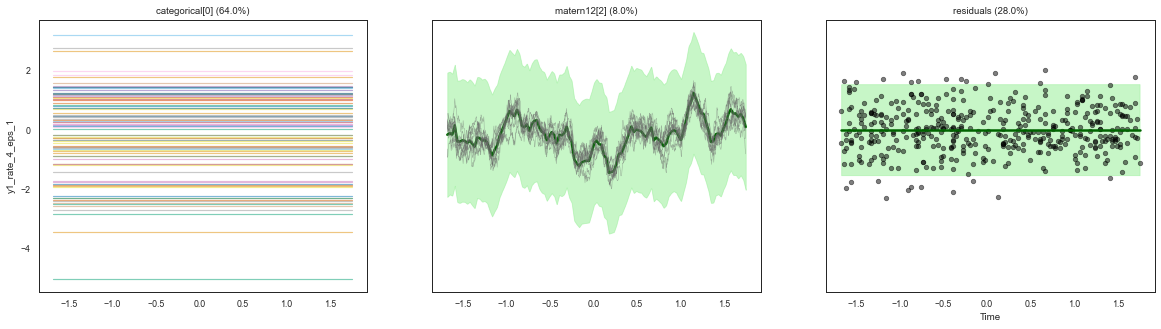

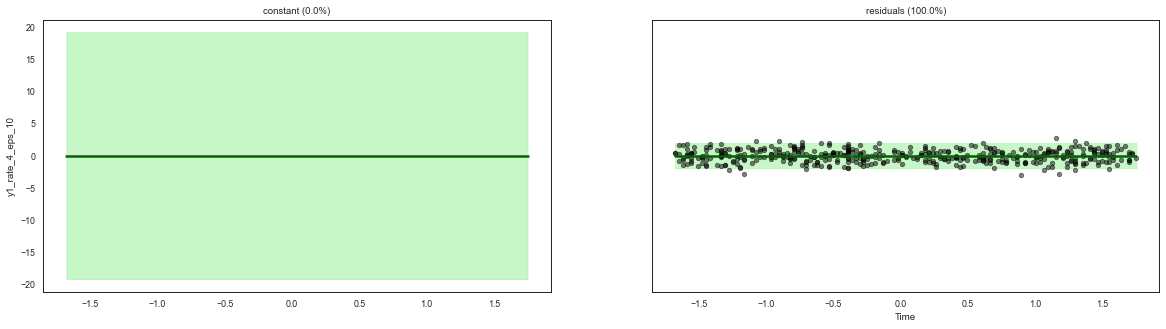

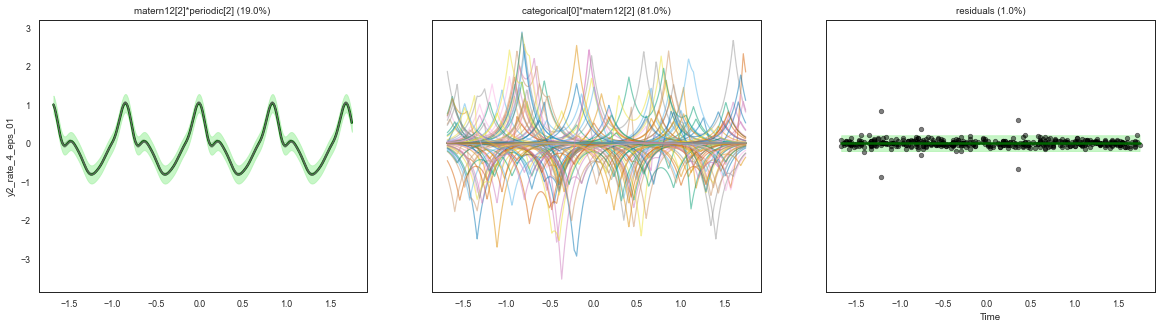

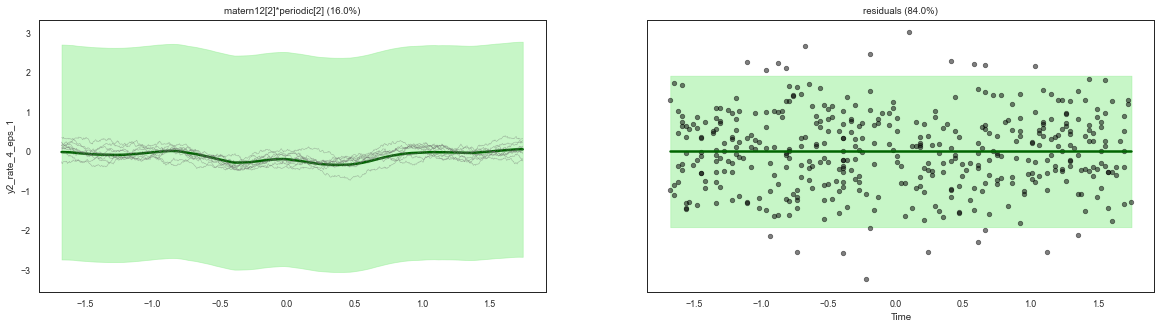

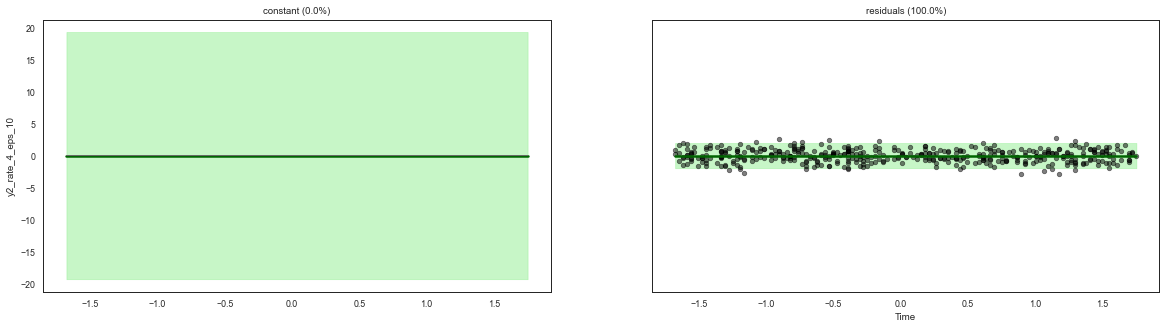

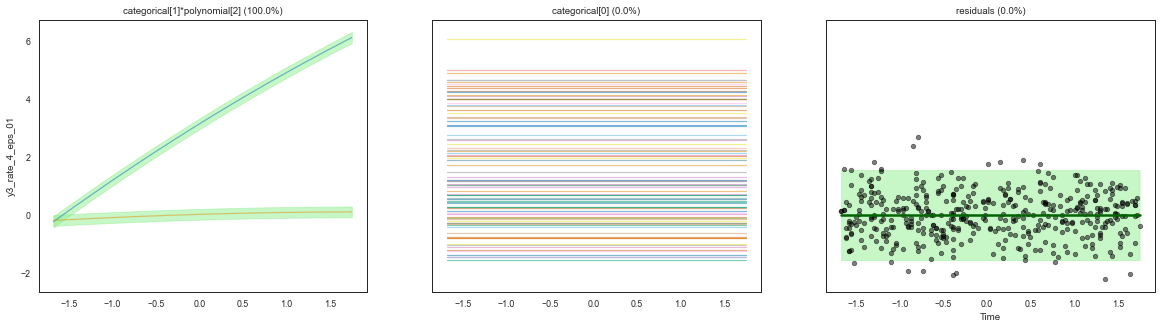

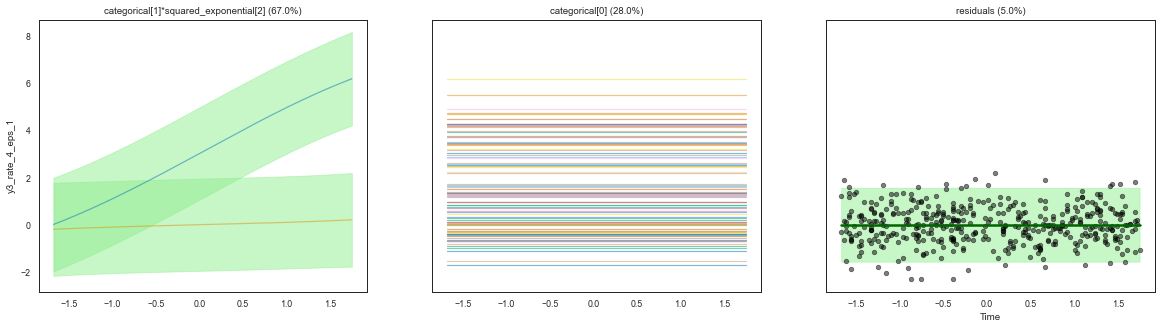

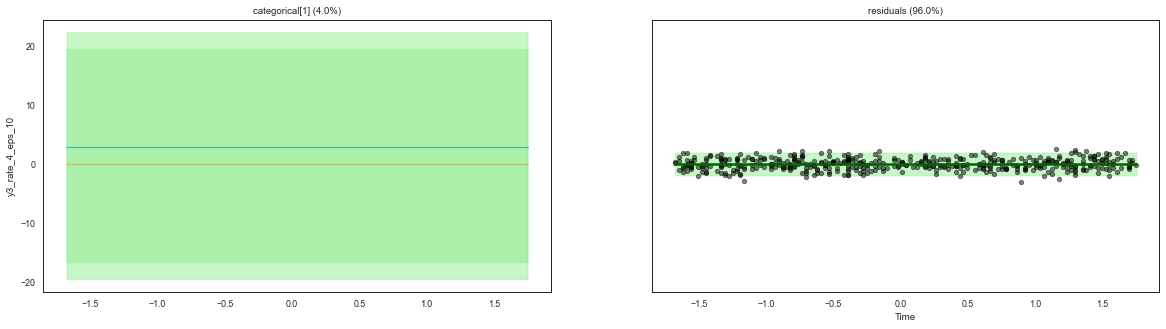

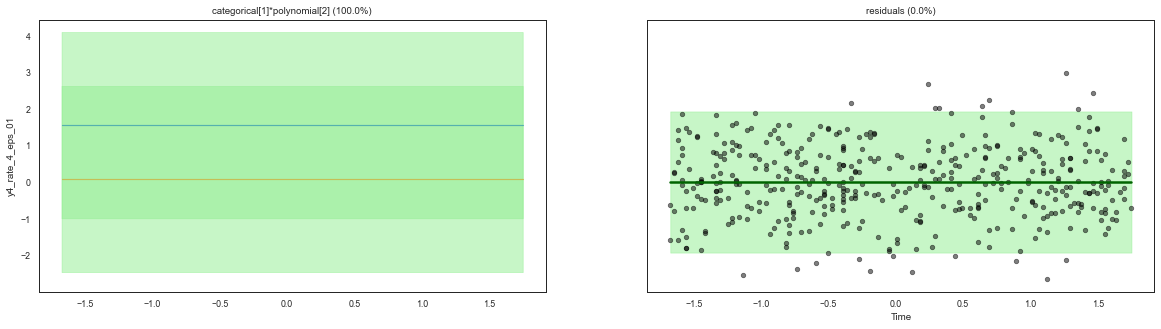

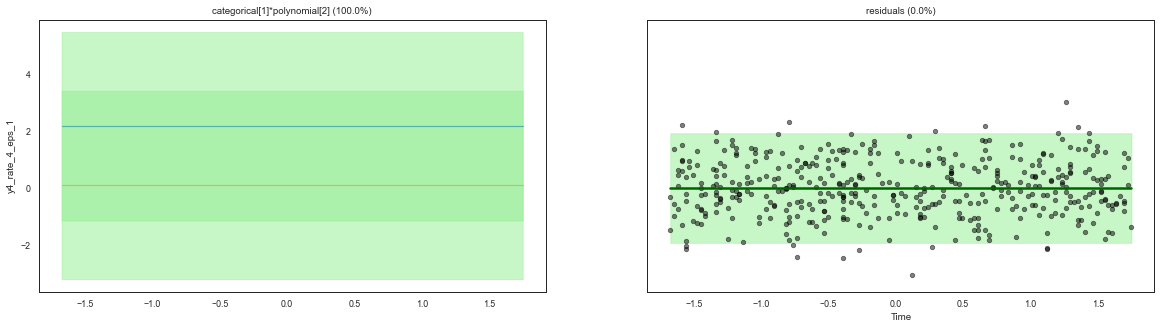

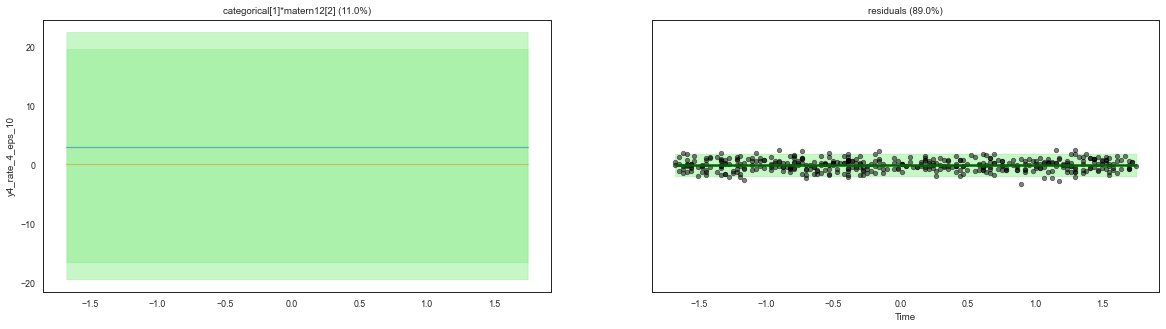

In [38]:
for i in range(16):
    f, a = pred_kernel_parts2(
        search_out_med[i]['models'][search_out_med[i]['best_model']]['model'],
        search_out_med[i]['best_model'],
        time_idx=2,
        unit_idx=0
    )
    f.set_size_inches(20, 5)
    # f.suptitle(sim_df[3].columns[i+3])
    a[0].set_ylabel(sim_df[rate].columns[i+3])
    #a[0].set_ylim(-3, 3)
    # a[1].set_xlabel('Time')
    #a[1].set_ylim(-3, 3)
    

<AxesSubplot:>

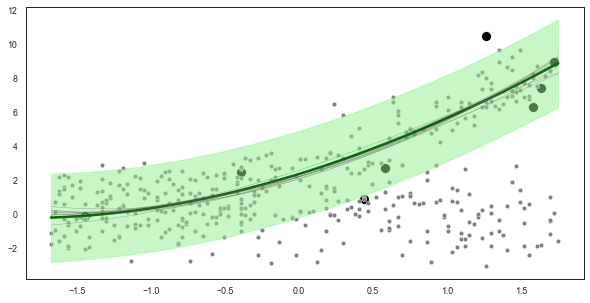

In [39]:
gp_predict_fun(
    gp=search_out_med[3]['models'][search_out_med[3]['best_model']]['model'],
    x_idx=2,
    unit_idx=0,
    unit_label=3
)

In [139]:
# Sample from the posterior for each 'best' model
np.random.seed(9102)
with tqdm_joblib(tqdm(desc="Posterior sampling", total=16)) as progress_bar:
    samples_out_med = Parallel(n_jobs=-2, verbose=1)(delayed(hmc_sampling)(
        model=search_out_med[i][0][search_out_med[i][2]][1],
        burn_in=500,
        samples=1000)
    for i in range(16))

Posterior sampling:   0%|                                              | 0/16 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
2021-12-04 00:10:43.308151: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-04 00:10:43.308875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-04 00:10:43.318462: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so c

In [140]:
# Save output
f = open("samples_out_med.pkl","wb")
pickle.dump(samples_out_med, f)
f.close()

### Large Rate

In [5]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               #gpflow.kernels.Matern32(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

rate = 12
# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Kernel search", total=16)) as progress_bar:
    search_out_large = Parallel(n_jobs=-3, verbose=1)(delayed(full_kernel_search)(
        X=sim_df[rate][['id', 'treat', 'time']].\
            assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
            to_numpy().\
            reshape(-1, 3),
        Y=sim_df[rate].drop(columns=['id', 'treat', 'time']).to_numpy()[:, i].reshape(-1, 1),
        kern_list=kernel_list,
        cat_vars=[0, 1],
        max_depth=5,
        early_stopping=True,
        prune=True,
        keep_all=False,
        lik='gaussian',
        random_seed=9102
    )
    for i in range(16))

Kernel search: 100%|█████████████████████████| 16/16 [2:27:03<00:00, 551.44s/it]


In [7]:
# Save output
f = open("search_out_large.pkl","wb")
pickle.dump(search_out_large, f)
f.close()

In [5]:
# Load if needed
search_out_large = pickle.load(open("search_out_large.pkl", "rb" ))

EOFError: Ran out of input

In [6]:
for x in range(16):
    print(f"Output: {sim_df[rate].columns[x+3]}, Kernel: {search_out_large[x]['best_model']}")
    if x in [3,6,9,12]:
        print('')

Output: y1_nonoise, Kernel: categorical[0]+matern12[2]
Output: y2_nonoise, Kernel: squared_exponential[2]*categorical[0]+squared_exponential[2]
Output: y3_nonoise, Kernel: categorical[1]*polynomial[2]+categorical[0]
Output: y4_nonoise, Kernel: categorical[1]*polynomial[2]+categorical[0]*squared_exponential[2]

Output: y1_rate_12_eps_01, Kernel: categorical[0]+matern12[2]
Output: y1_rate_12_eps_1, Kernel: categorical[0]+matern12[2]
Output: y1_rate_12_eps_10, Kernel: categorical[0]

Output: y2_rate_12_eps_01, Kernel: squared_exponential[2]*categorical[0]+periodic[2]
Output: y2_rate_12_eps_1, Kernel: periodic[2]+matern12[2]*categorical[0]
Output: y2_rate_12_eps_10, Kernel: constant

Output: y3_rate_12_eps_01, Kernel: categorical[1]*squared_exponential[2]+categorical[0]
Output: y3_rate_12_eps_1, Kernel: categorical[1]*squared_exponential[2]+categorical[0]
Output: y3_rate_12_eps_10, Kernel: categorical[1]*polynomial[2]

Output: y4_rate_12_eps_01, Kernel: categorical[1]*polynomial[2]+categor

In [49]:
for x in range(16):
    print(f'Output: {sim_df[30].columns[x+3]}, Kernel: {search_out_large[x][2]}')
    if x in [3,6,9,12]:
        print('')

Output: y1_nonoise, Kernel: categorical[0]+matern12[2]
Output: y2_nonoise, Kernel: squared_exponential[2]*categorical[0]
Output: y3_nonoise, Kernel: categorical[0]*polynomial[2]
Output: y4_nonoise, Kernel: categorical[1]*polynomial[2]

Output: y1_rate_30_eps_01, Kernel: categorical[0]+matern12[2]
Output: y1_rate_30_eps_1, Kernel: categorical[0]+matern12[2]
Output: y1_rate_30_eps_10, Kernel: constant

Output: y2_rate_30_eps_01, Kernel: periodic[2]+categorical[0]
Output: y2_rate_30_eps_1, Kernel: squared_exponential[2]*categorical[0]
Output: y2_rate_30_eps_10, Kernel: constant

Output: y3_rate_30_eps_01, Kernel: categorical[0]*polynomial[2]
Output: y3_rate_30_eps_1, Kernel: categorical[0]*polynomial[2]
Output: y3_rate_30_eps_10, Kernel: categorical[1]*polynomial[2]

Output: y4_rate_30_eps_01, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_30_eps_1, Kernel: categorical[1]*polynomial[2]
Output: y4_rate_30_eps_10, Kernel: categorical[1]*polynomial[2]


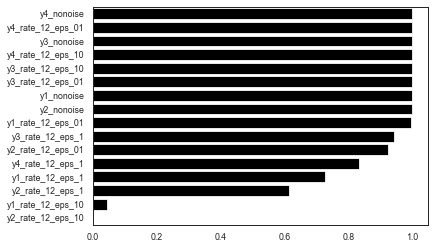

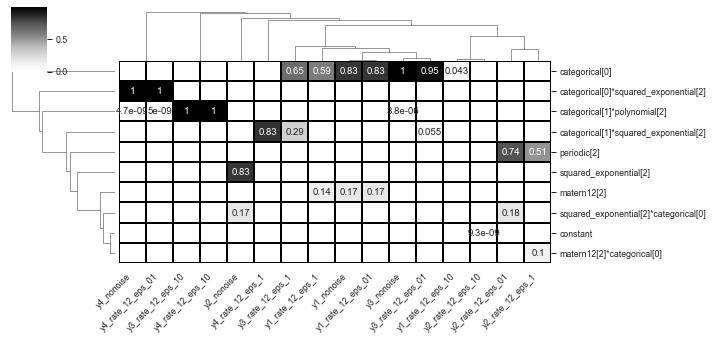

In [7]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in search_out_large]
var_components = [x['var_exp'] for x in search_out_large]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]


sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=sim_df[rate].columns[3:][np.argsort(var_explained)[::-1]],
    color='black'
)

kernels = [x['best_model'].split('+') for x in search_out_large]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

clm = sns.clustermap(pd.DataFrame(kernel_array, 
                            index=sim_df[rate].columns[3:], #np.arange(Y.shape[1]),
                            columns=distinct_kernels).transpose(),
              figsize=(10, 5),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              annot=True)
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
for t in clm.ax_heatmap.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.

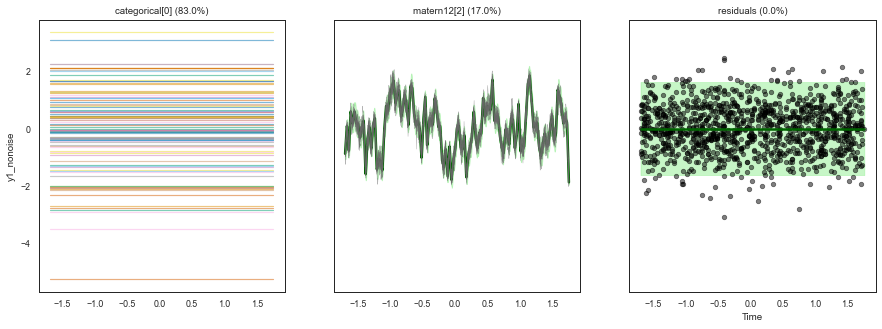

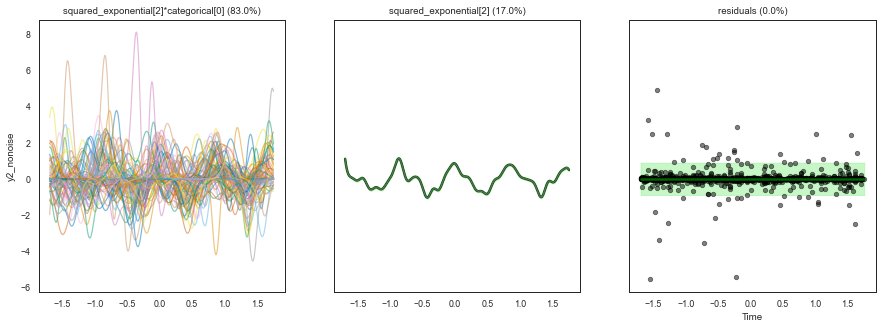

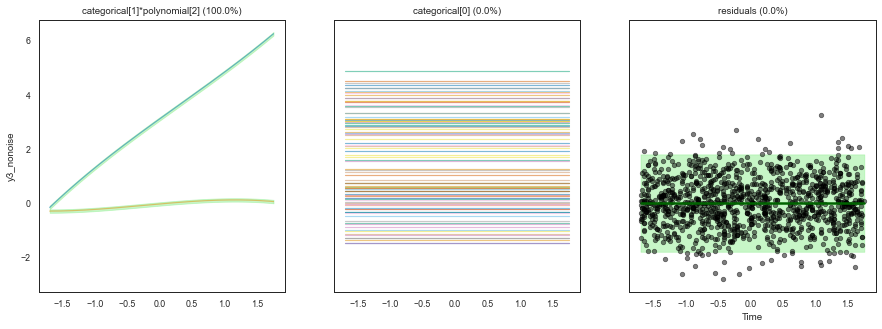

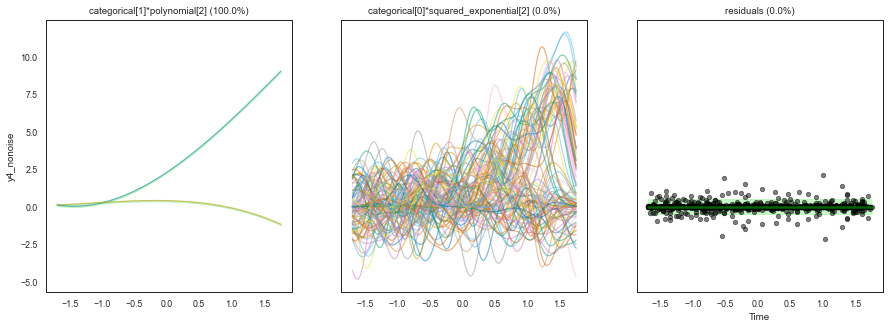

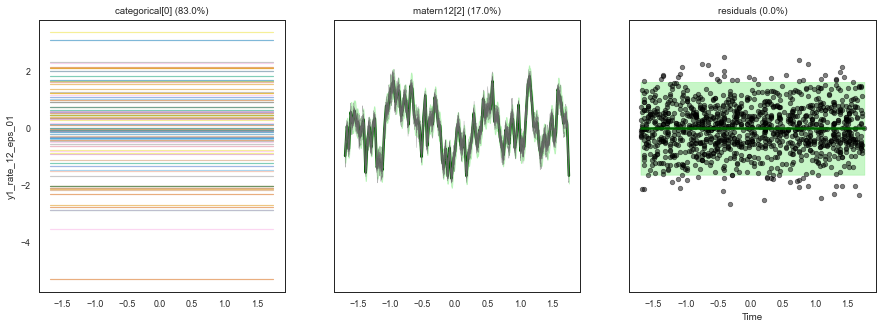

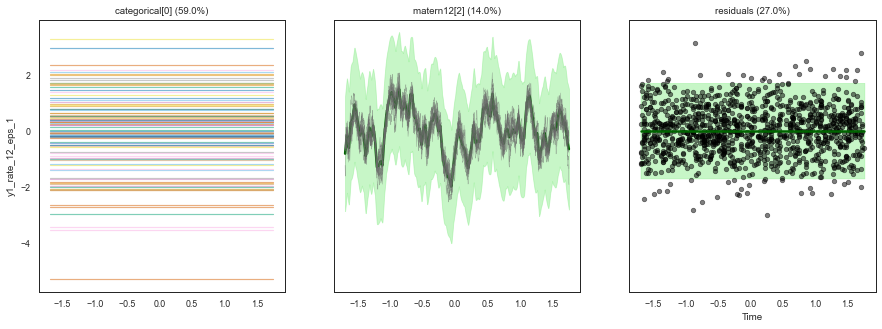

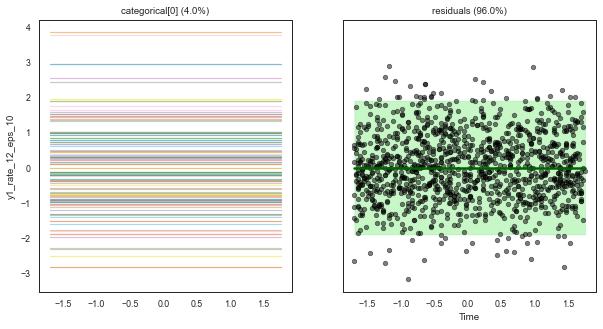

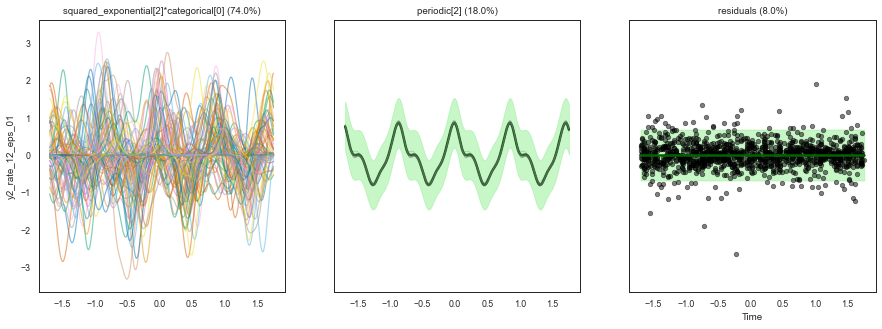

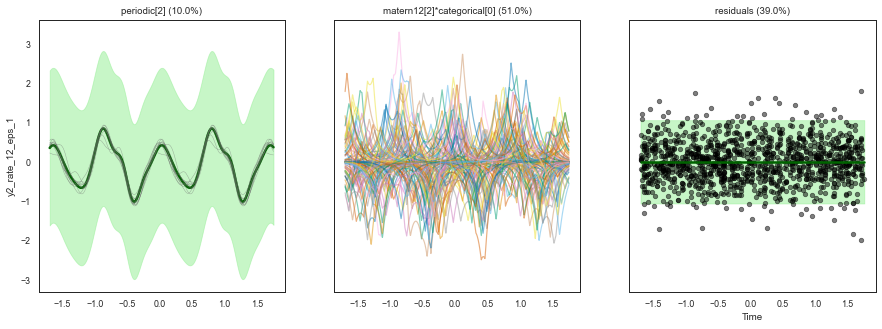

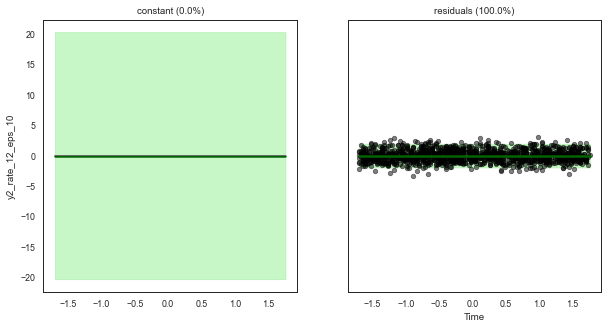

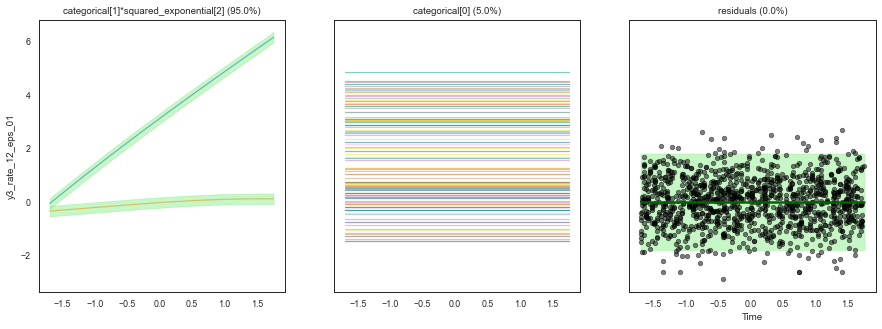

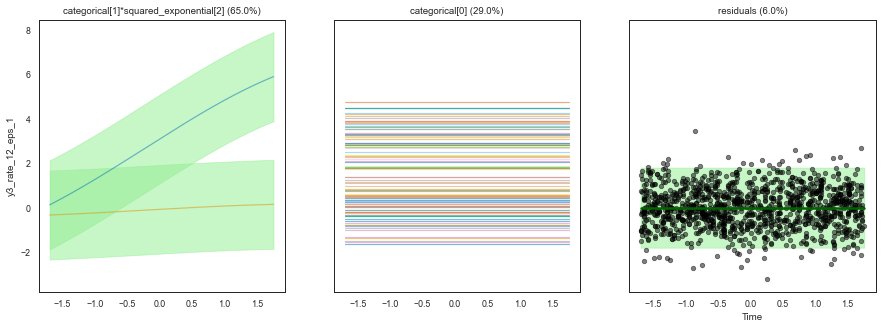

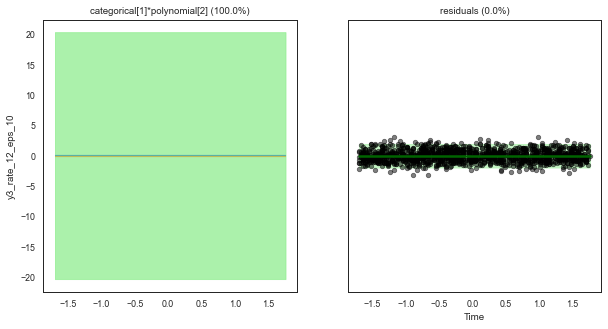

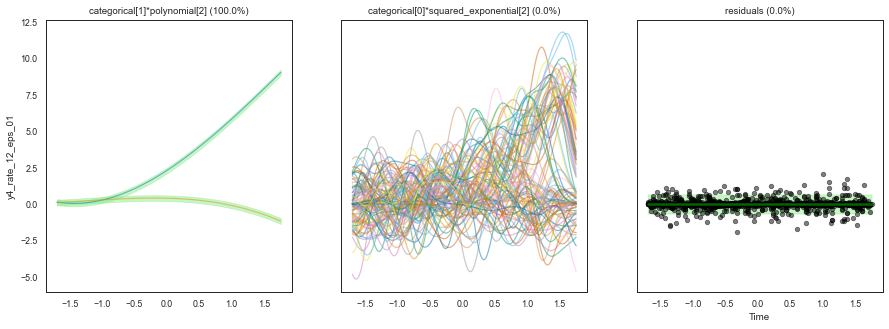

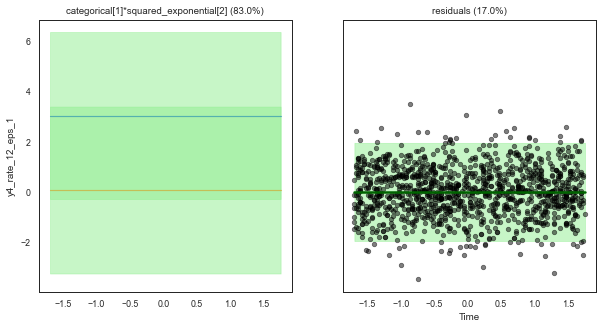

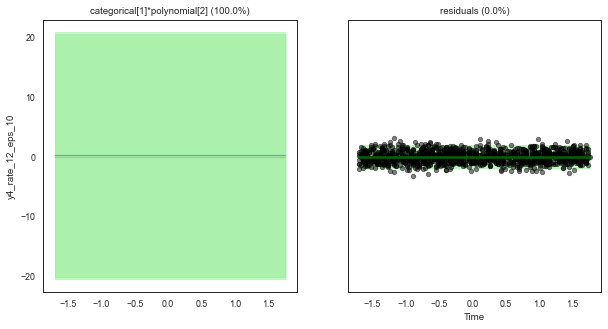

In [9]:
for i in range(16):
    # if i == 2:
    #     continue
    f, a = pred_kernel_parts2(
        search_out_large[i]['models'][search_out_large[i]['best_model']]['model'],
        search_out_large[i]['best_model'],
        time_idx=2,
        unit_idx=0
    )
    #f.set_size_inches(7, 4)
    # f.suptitle(sim_df[3].columns[i+3])
    a[0].set_ylabel(sim_df[rate].columns[i+3])
    #a[0].set_ylim(-3, 3)
    # a[1].set_xlabel('Time')
    #a[1].set_ylim(-3, 3)
    

### Dive into specific outcome

In [9]:
%%time
# Test out 
foo1_periodic = kernel_test(
    X=sim_df[4][['id', 'treat', 'time']].\
            assign(time = (sim_df[4].time - med_time_mean)/med_time_std).\
            to_numpy().\
            reshape(-1, 3),
    Y=sim_df[30].y2_nonoise.to_numpy().reshape(-1, 1),
    k=gpflow.kernels.Matern12(active_dims=[2])*Categorical(active_dims=[0]) + \
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

CPU times: user 29min 5s, sys: 13.8 s, total: 29min 18s
Wall time: 6min 41s


In [10]:
foo1_periodic

(<gpflow.models.gpr.GPR object at 0x7f8c50e45ac0>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 11.2465      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.157626    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────

In [11]:
%%time
# Test out 
foo1_periodic2 = kernel_test(
    X=sim_df[30][['id', 'treat', 'time']].\
            assign(time = (sim_df[30].time - med_time_mean)/med_time_std).\
            to_numpy().\
            reshape(-1, 3),
    Y=sim_df[30].y2_nonoise.to_numpy().reshape(-1, 1),
    k=Categorical(active_dims=[0]) + \
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

CPU times: user 11min 10s, sys: 1.16 s, total: 11min 11s
Wall time: 2min 35s


In [18]:
foo1_periodic2

(<gpflow.models.gpr.GPR object at 0x7f8cc1046a90>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.107818 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.648962 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───

In [12]:
%%time
med_time_mean = sim_df[30].time.mean()
med_time_std = sim_df[30].time.std()

foo_search_one = full_kernel_search(
    X=sim_df[30][['id', 'treat', 'time']].\
        assign(time = (sim_df[30].time - med_time_mean)/med_time_std).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[30].y2_nonoise.to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.Matern12(), 
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())],
    cat_vars=[0, 1],
    max_depth=1, #5,
    early_stopping=False, #True,
    prune=False, #True,
    keep_all=True, #False,
    lik='gaussian',
    keep_only_best=False,
    random_seed=9102,
    verbose=True
)

Working on depth 1 now
Base kernel: None
Working on feature 0 now
Current kernel being tested: categorical[0]
New best log likelihood: -4505.440613581214
New best log likelihood: -4505.440613580871
Model: categorical, BIC: 9026.86
Current kernel being tested: constant
New best log likelihood: -4575.121152761253
Model: constant, BIC: 9158.23
Working on feature 1 now
Current kernel being tested: categorical[1]
New best log likelihood: -4567.843970028548
New best log likelihood: -4567.843970028354
Model: categorical, BIC: 9151.67
Working on feature 2 now
Current kernel being tested: matern12[2]
New best log likelihood: -4304.724850251856
Model: matern12, BIC: 8633.42
Current kernel being tested: squared_exponential[2]
New best log likelihood: -4293.73208843776
Model: squared_exponential, BIC: 8611.44
Current kernel being tested: periodic[2]
New best log likelihood: -4277.036950811822
New best log likelihood: -4276.998324581747
New best log likelihood: -4276.998297461239
Model: periodic, B

In [17]:
# Obviously it looks like the periodic is the best
[(k, v[2]) for k, v in foo_search_one[0].items()]

[('categorical[0]', 9026.86),
 ('constant', 9158.23),
 ('categorical[1]', 9151.67),
 ('matern12[2]', 8633.42),
 ('squared_exponential[2]', 8611.44),
 ('periodic[2]', 8585.96)]

In [ ]:
%%time
# Test out 
foo1_periodic3 = kernel_test(
    X=sim_df[30][['id', 'treat', 'time']].\
            assign(time = (sim_df[30].time - med_time_mean)/med_time_std).\
            to_numpy().\
            reshape(-1, 3),
    Y=sim_df[30].y2_nonoise.to_numpy().reshape(-1, 1),
    k=Categorical(active_dims=[0]) + \
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

In [120]:
%%time
rate = 3
foo_search_test = full_kernel_search(
    X=sim_df[rate][['id', 'treat', 'time']].\
        assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[rate].y2_nonoise.to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.Matern12(), 
               #gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())],
    cat_vars=[0, 1],
    max_depth=3,
    early_stopping=False,
    prune=False,
    keep_all=True, #False,
    lik='gaussian',
    keep_only_best=False,
    random_seed=9102,
    verbose=False
)

CPU times: user 2min 34s, sys: 17.8 s, total: 2min 52s
Wall time: 1min 17s


In [115]:
foo_search_test['best_model']

'categorical[0]*matern12[2]+periodic[2]'

In [ ]:
%%time
rate = 30
foo_search_med = full_kernel_search(
    X=sim_df[rate][['id', 'treat', 'time']].\
        assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[rate].y2_nonoise.to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.Matern12(), 
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())],
    cat_vars=[0, 1],
    max_depth=3,
    early_stopping=True,
    prune=False,
    keep_all=False,
    lik='gaussian',
    keep_only_best=False,
    random_seed=9102,
    verbose=False
)

In [ ]:
sorted([(k, v['bic']) for k, v in foo_search_med['models'].items()], key = lambda x: x[1])[:5]

In [173]:
sorted([(k, v['bic']) for k, v in foo_search_med['models'].items()], key = lambda x: x[1])[:5]

[('periodic[2]+categorical[0]*squared_exponential[2]', 2255.17),
 ('periodic[2]+categorical[0]*matern12[2]', 2332.86),
 ('periodic[2]+categorical[0]*periodic[2]', 2883.76),
 ('periodic[2]+categorical[0]', 2926.76),
 ('periodic[2]+categorical[0]*categorical[1]', 2926.76)]

In [174]:
foo_search_med['edges']

[('periodic[2]', 'periodic[2]+categorical[0]'),
 ('periodic[2]', 'periodic[2]+categorical[1]'),
 ('periodic[2]', 'periodic[2]+matern12[2]'),
 ('periodic[2]', 'periodic[2]+squared_exponential[2]'),
 ('periodic[2]', 'periodic[2]+periodic[2]'),
 ('periodic[2]', 'periodic[2]*categorical[0]'),
 ('periodic[2]', 'periodic[2]*categorical[1]'),
 ('periodic[2]', 'periodic[2]*matern12[2]'),
 ('periodic[2]', 'periodic[2]*squared_exponential[2]'),
 ('periodic[2]', 'periodic[2]*periodic[2]'),
 ('periodic[2]+categorical[0]', 'periodic[2]+categorical[0]+categorical[0]'),
 ('periodic[2]+categorical[0]', 'periodic[2]+categorical[0]+categorical[1]'),
 ('periodic[2]+categorical[0]', 'periodic[2]+categorical[0]+matern12[2]'),
 ('periodic[2]+categorical[0]',
  'periodic[2]+categorical[0]+squared_exponential[2]'),
 ('periodic[2]+categorical[0]', 'periodic[2]+categorical[0]+periodic[2]'),
 ('periodic[2]+categorical[0]', 'periodic[2]*categorical[0]+categorical[0]'),
 ('periodic[2]+categorical[0]', 'periodic[2]

In [168]:
kernel_test(
    X=sim_df[rate][['id', 'treat', 'time']].\
        assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[rate].y2_nonoise.to_numpy().reshape(-1, 1),
    k=Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[2]) + \
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

(<gpflow.models.gpr.GPR object at 0x7f8b838b88b0>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.838789    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  1.48988     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────

In [34]:
%%time
# Test out 
rate=4
foo10_periodic3 = kernel_test(
    X=sim_df[rate][['id', 'treat', 'time']].\
        assign(time = (sim_df[rate].time - sim_df[rate].time.mean())/sim_df[rate].time.std()).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[rate].y2_nonoise.to_numpy().reshape(-1, 1),
    k=gpflow.kernels.Matern12(active_dims=[2])*Categorical(active_dims=[0]) + \
        gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(active_dims=[2]))
)

CPU times: user 14 s, sys: 1.21 s, total: 15.3 s
Wall time: 5.2 s


In [35]:
foo10_periodic3

(<gpflow.models.gpr.GPR object at 0x7fad39c1c610>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.51688     │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.132798    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────

In [4]:
%%time
med_time_mean = sim_df[30].time.mean()
med_time_std = sim_df[30].time.std()

foo_search = full_kernel_search(
    X=sim_df[30][['id', 'treat', 'time']].\
        assign(time = (sim_df[30].time - med_time_mean)/med_time_std).\
        to_numpy().\
        reshape(-1, 3),
    Y=sim_df[30].y2_nonoise.to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.Matern12(), 
               gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())],
    cat_vars=[0, 1],
    max_depth=3, #5,
    early_stopping=False, #True,
    prune=False, #True,
    keep_all=False,
    lik='gaussian',
    keep_only_best=False,
    random_seed=9102,
    verbose=True
)

2021-12-20 09:53:11.339200: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-20 09:53:11.440235: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Working on depth 1 now
Base kernel: None
Working on feature 0 now
Current kernel being tested: categorical[0]
New best log likelihood: -4505.440613581214
New best log likelihood: -4505.440613580871
Model: categorical, BIC: 9026.86
Current kernel being tested: constant
New best log likelihood: -4575.121152761253
Model: constant, BIC: 9158.23
Working on feature 1 now
Current kernel being tested: categorical[1]
New best log likelihood: -4567.843970028548
New best log likelihood: -4567.843970028354
Model: categorical, BIC: 9151.67
Working on feature 2 now
Current kernel being tested: matern12[2]
New best log likelihood: -4304.724850251856
Model: matern12, BIC: 8633.42
Current kernel being tested: squared_exponential[2]
New best log likelihood: -4293.73208843776
Model: squared_exponential, BIC: 8611.44
Current kernel being tested: periodic[2]
New best log likelihood: -4277.036950811822
New best log likelihood: -4276.998324581747
New best log likelihood: -4276.998297461239
Model: periodic, B

2021-12-20 10:54:29.415743: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Optimization not successful, skipping. Error: Graph execution error:

Detected at node 'gradient_tape/triangular_solve/MatrixTriangularSolve' defined at (most recent call last):
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/tor

2021-12-20 10:54:29.867748: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Optimization not successful, skipping. Error: Graph execution error:

Detected at node 'gradient_tape/triangular_solve/MatrixTriangularSolve' defined at (most recent call last):
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/tor

2021-12-20 10:54:30.299492: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


In [5]:
foo_search[0].keys()

dict_keys(['periodic[2]', 'periodic[2]+categorical[0]', 'periodic[2]+categorical[0]+matern12[2]'])

In [6]:
foo_search[1:]

([('periodic[2]', 'periodic[2]*categorical[0]'),
  ('periodic[2]', 'periodic[2]*categorical[1]'),
  ('periodic[2]', 'periodic[2]*matern12[2]'),
  ('periodic[2]', 'periodic[2]*squared_exponential[2]'),
  ('periodic[2]', 'periodic[2]*periodic[2]')],
 'periodic[2]+categorical[0]',
 [0.6479845992475521, 0.10781871834413688, 0.945])

In [7]:
sorted([(k, v[2]) for k,v in foo_search[0].items()], key=lambda x: x[1])[:10]

[('periodic[2]+categorical[0]', 8422.12),
 ('periodic[2]+categorical[0]+matern12[2]', 8435.82),
 ('periodic[2]', 8585.96)]

In [18]:
foo_search[0]['categorical[0]*matern12[2]+categorical[1]'][1]

<gpflow.models.gpr.GPR object at 0x7fe1f8ecabe0>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.00571  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].kernels[1].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1        │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.130451 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.47014  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance                       │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1e-06    │
╘═══════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛

In [26]:
foo_search[0]['categorical[0]*matern12[2]+matern12[2]'][1]

<gpflow.models.gpr.GPR object at 0x7fe2189db2e0>
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.961728 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[0].kernels[1].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │  1        │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[0].kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.123466 │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  1.88444  │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.kernels[1].lengthscales            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 48.1881   │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance                       │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  1e-06    │
╘═══════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════╛

In [12]:
foo_search[0]['matern12[2]*categorical[0]+periodic[2]'][1]

<gpflow.models.gpr.GPR object at 0x7f8359902dc0>
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.3154      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].kernels[0].lengthscales  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.164194    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].kernels[1].variance      │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.432309    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.719476    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.884711    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance                        │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.44588e-06 │
╘════════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 1080x360 with 3 Axes>,
 array([<AxesSubplot:title={'center':'periodic[2] (38.0%)'}>,
        <AxesSubplot:title={'center':'categorical[0] (6.0%)'}>,
        <AxesSubplot:title={'center':'residuals (56.0%)'}, xlabel='Time'>],
       dtype=object))

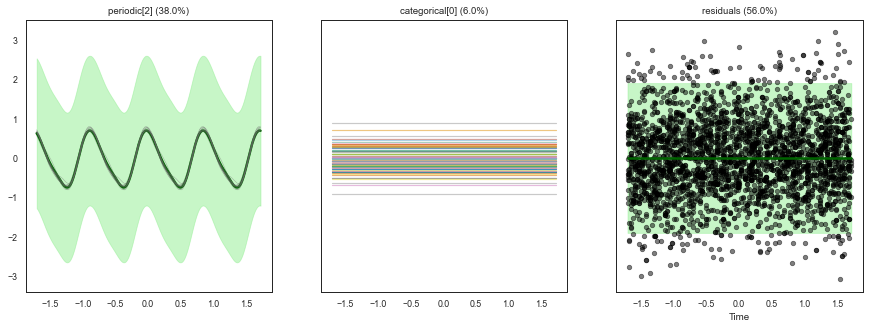

In [8]:
pred_kernel_parts2(
    m=foo_search[0]['periodic[2]+categorical[0]'][1],
    k_names='periodic[2]+categorical[0]',
    unit_idx=0,
    time_idx=2
)